<a href="https://colab.research.google.com/github/aditya-shriwastava/colab-notebooks/blob/master/visual_odometry.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Issues:
1. Stable relative scale computation.
2. Improving accuracy by:
  1. Pose Graph optimization
  2. Windowed Bundle Adjustment

# pip3 install

In [1]:
!pip3 install scikit-image

# import

In [35]:
import os

import numpy as np

import cv2
from google.colab.patches import cv2_imshow

import matplotlib.pyplot as plt
%matplotlib inline

from skimage.measure import ransac

from tqdm import tqdm, trange

# Load kitti dataset

In [36]:
if "2011_09_26_drive_0020_sync.zip" not in os.listdir():
  !wget https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
  !unzip  2011_09_26_drive_0020_sync.zip >/dev/null

dataset_dir = "./2011_09_26/2011_09_26_drive_0020_sync/image_02"
imgs_dir = os.path.join(dataset_dir, "data")

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
kitti_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

--2022-01-18 23:57:02--  https://s3.eu-central-1.amazonaws.com/avg-kitti/raw_data/2011_09_26_drive_0020/2011_09_26_drive_0020_sync.zip
Resolving s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)... 52.219.169.213
Connecting to s3.eu-central-1.amazonaws.com (s3.eu-central-1.amazonaws.com)|52.219.169.213|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 367093728 (350M) [application/zip]
Saving to: ‘2011_09_26_drive_0020_sync.zip’

2011_09_26_drive_00 100%[===================>] 350.09M  30.7MB/s    in 13s     

2022-01-18 23:57:15 (27.9 MB/s) - ‘2011_09_26_drive_0020_sync.zip’ saved [367093728/367093728]



In [37]:
kitti_cam_calib = np.array([[7.215377e+02,0.000000e+00,6.095593e+02],
                            [0.000000e+00,7.215377e+02,1.728540e+02],
                            [0.000000e+00,0.000000e+00,1.000000e+00]])

# Load freiburgxyz525 dataset

In [3]:
if "test_freiburgxyz525.mp4" not in os.listdir():
  !wget https://github.com/geohot/twitchslam/raw/master/videos/test_freiburgxyz525.mp4
if "test_freiburgxyz525.npz" not in os.listdir():
  !wget https://github.com/geohot/twitchslam/raw/master/videos/test_freiburgxyz525.npz

--2022-01-18 23:07:38--  https://github.com/geohot/twitchslam/raw/master/videos/test_freiburgxyz525.mp4
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/geohot/twitchslam/master/videos/test_freiburgxyz525.mp4 [following]
--2022-01-18 23:07:38--  https://raw.githubusercontent.com/geohot/twitchslam/master/videos/test_freiburgxyz525.mp4
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 5396374 (5.1M) [application/octet-stream]
Saving to: ‘test_freiburgxyz525.mp4’

test_freiburgxyz525 100%[===================>]   5.15M  --.-KB/s    in 0.02s   

2022-01-18 23:07:38 (260 MB/s) - ‘test_freiburgxyz525.mp4’

In [108]:
freiburgxyz525_cap = cv2.VideoCapture("./test_freiburgxyz525.mp4")

W = int(freiburgxyz525_cap.get(cv2.CAP_PROP_FRAME_WIDTH))
H = int(freiburgxyz525_cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
F = 525

freiburgxyz525_K = np.array([[F,0,W//2],[0,F,H//2],[0,0,1.]])

freiburgxyz525_imgs = []
for i in tqdm(range(int(freiburgxyz525_cap.get(cv2.CAP_PROP_FRAME_COUNT)))):
  ret, img = freiburgxyz525_cap.read()
  assert ret
  freiburgxyz525_imgs.append(img)

freiburgxyz525_cap.release ()
freiburgxyz525_imgs = np.array(freiburgxyz525_imgs)

100%|██████████| 798/798 [00:04<00:00, 180.08it/s]


In [109]:
 gt = np.load('test_freiburgxyz525.npz')['pose']

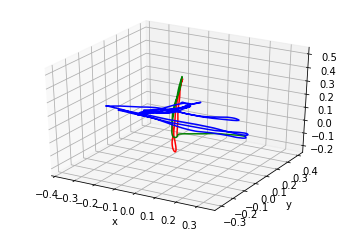

In [111]:
# Plot trajector
ax = plt.axes(projection ='3d')
ax.plot3D(gt[:100,0,3], gt[:100,1,3], gt[:100,2,3], color='red')
ax.plot3D(gt[100:200,0,3], gt[100:200,1,3], gt[100:200,2,3], color='green')
ax.plot3D(gt[200:,0,3], gt[200:,1,3], gt[200:,2,3], color='blue')
plt.xlabel('x')
plt.ylabel('y')
axisEqual3D(ax)
plt.show()

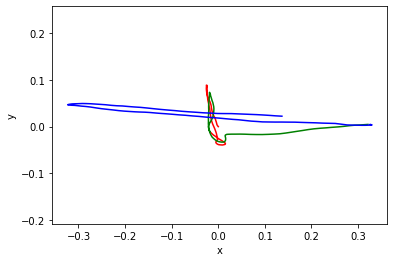

In [117]:
plt.plot(gt[:100,0,3], gt[:100,1,3], color='red')
plt.plot(gt[100:200,0,3], gt[100:200,1,3], color='green')
plt.plot(gt[200:300,0,3], gt[200:300,1,3], color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.axis('equal')
plt.show()

# Load deer_robot dataset

In [ ]:
if "deer_robot.zip" not in os.listdir():
  !wget https://www.doc.ic.ac.uk/~wl208/lmdata/deer_robot.zip
  !unzip  deer_robot.zip >/dev/null

imgs_dir = "./deer_robot/cam0/data"
poses_gt_file = "./deer_robot/poses.gt"

imgs_file_name = os.listdir(imgs_dir)
imgs_file_name.sort()

imgs_file_path = [os.path.join(imgs_dir, img_file_name) for img_file_name in imgs_file_name]
deer_robot_imgs = np.array([cv2.imread(img_file_path) for img_file_path in imgs_file_path])

def load_poses_gt():
  with open(poses_gt_file, 'r') as fd:
    positions = []
    orientations = []
    for line in fd:
      if line[0] == '#':
        continue

      split = line.split(',')
      px = float(split[1])
      py = float(split[2])
      pz = float(split[3])
      p = [px, py, pz]
      positions.append(p)

      qw = float(split[4])
      qx = float(split[5])
      qy = float(split[6])
      qz = float(split[7])
      q = [qx, qy, qz, qw]
      orientations.append(q)
  return np.array(positions), np.array(orientations)

deer_robot_p, deer_robot_q = load_poses_gt()

In [ ]:
deer_robot_cam_calib = np.array([
  [600, 0, 320],
  [0, 600, 240],
  [0,   0,   1]
], dtype=np.float)

# Disp utils

In [105]:
def axisEqual3D(ax):
    extents = np.array([getattr(ax, 'get_{}lim'.format(dim))() for dim in 'xyz'])
    sz = extents[:,1] - extents[:,0]
    centers = np.mean(extents, axis=1)
    maxsize = max(abs(sz))
    r = maxsize/2
    for ctr, dim in zip(centers, 'xyz'):
        getattr(ax, 'set_{}lim'.format(dim))(ctr - r, ctr + r)
        
def disp(img_tn1, kps_tn1, kps_t):
  disp_img = img_tn1.copy()
  for kp_tn1, kp_t in zip(kps_tn1, kps_t):
    start_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 1, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, end_point, (0, 255, 0), 1)
  cv2_imshow(disp_img)

def disp2(img_tn2, kps_tn2, kps_tn1, kps_t):
  disp_img = img_tn2.copy()
  for kp_tn2, kp_tn1, kp_t in zip(kps_tn2, kps_tn1, kps_t):
    start_point = tuple(kp_tn2)
    middle_point = tuple(kp_tn1)
    end_point = tuple(kp_t)
    disp_img = cv2.circle(disp_img, start_point, 1, (0, 0, 255), 2)
    disp_img = cv2.line(disp_img, start_point, middle_point, (0, 255, 0), 1)
    disp_img = cv2.line(disp_img, middle_point, end_point, (255, 0, 0), 1)
  cv2_imshow(disp_img)

# Essential matrix utils

In [56]:
def triangulate(x_tn1, x_t, R, t):
  """
  Args:
    x_tn1: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_tn1 of point to triangulate.
    x_t: numpy array of shape (3,) representing normalized homogeneous
      coordinate in img_t of point to triangulate.
    R: numpy array of shape (3,3) representing rotation of camera frame
      at time t wrt camera frame at time tn1.
    t: numpy array of shape (3,) representing baseline vector between 
    camera frame at time t and camera frame at time tn1.
  """
  A = np.array([
    [np.dot(x_tn1, x_tn1), -np.dot(R @ x_t, x_tn1)],
    [np.dot(x_tn1, R @ x_t), -np.dot(R @ x_t, R @ x_t)]
  ])
  b = np.array([np.dot(t, x_tn1) ,np.dot(t, R @ x_t)])
  alpha, beta = np.linalg.inv(A) @ b
  p_tn1 = alpha * x_tn1
  p_t = t + (beta * (R @ x_t))
  return (p_tn1 + p_t)/2

def essential_to_Rt(E, xs_tn1, xs_t):
  """
  Args:
    E: numpy array of shape (3,3) representing Essential matrix.
    xs_tn1: numpy array of shape (N, 3) representing normalized homogeneous
      coordinates in img_tn1.
    xs_t: numpy array of shape (N, 3) representing normalized homogeneous
      coordinates in img_t corresponding to xs_tn1.
  """
  u,s,vt = np.linalg.svd(E)
  w = np.array([[0,-1,0],
                [1,0,0],
                [0,0,1]])
  R1 = u @ w.T @ vt
  if np.linalg.det(R1) < 0:
    R1 = -R1
  R2 = u @ w @ vt
  if np.linalg.det(R2) < 0:
    R2 = -R2

  t1 = u @ w @ np.diag(s) @ u.T
  t1 = np.array([t1[2,1], t1[0,2], t1[1,0]])
  t1 = t1#/np.linalg.norm(t1)
  t2 = -t1

  # Resolve ambiguities by triangulation
  for x_tn1, x_t in zip(xs_tn1, xs_t):
    try:
      p11_tn1 = triangulate(x_tn1, x_t, R1, t1)
      p11_t = R1.T @ (p11_tn1 - t1)
      if p11_tn1[2] > 0 and p11_t[2] > 0:
        return R1, t1

      p12_tn1 = triangulate(x_tn1, x_t, R1, t2)
      p12_t = R1.T @ (p12_tn1 - t2)
      if p12_tn1[2] > 0 and p12_t[2] > 0:
        return R1, t2
      
      p21_tn1 = triangulate(x_tn1, x_t, R2, t1)
      p21_t = R2.T @ (p21_tn1 - t1)
      if p21_tn1[2] > 0 and p21_t[2] > 0:
        return R2, t1

      p22_tn1 = triangulate(x_tn1, x_t, R2, t2)
      p22_t = R2.T @ (p22_tn1 - t2)
      if p22_tn1[2] > 0 and p22_t[2] > 0:
        return R2, t2
    except:
      continue
  
  print('Failed to resolve ambiguities!!')
  return R1, t1
  raise Exception('Failed to resolve ambiguities!!')

In [57]:
class EssentialMatrixTransform():
  def __init__(self):
    # param contains essential matrix
    self.params = np.eye(3)

  def estimate(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    # Setup constraint matrix
    A = np.column_stack((
      kps_tn1[:,0] * kps_t[:,0],
      kps_tn1[:,0] * kps_t[:,1],
      kps_tn1[:,0] * kps_t[:,2],
      kps_tn1[:,1] * kps_t[:,0],
      kps_tn1[:,1] * kps_t[:,1],
      kps_tn1[:,1] * kps_t[:,2],
      kps_tn1[:,2] * kps_t[:,0],
      kps_tn1[:,2] * kps_t[:,1],
      kps_tn1[:,2] * kps_t[:,2]
    ))

    # Solve for nullsapce of the constraint matrix
    u, s, vt = np.linalg.svd(A)
    E = vt[-1,:].reshape(3,3)

    # Enforcing Constraints:
    # 1. First and Second singular values should be equal
    # 2. Third singular value should be zero
    u, s, vt = np.linalg.svd(E)
    s[0] = s[1] = (s[0] + s[1])/2
    s[2] = 0
    self.params = u @ np.diag(s) @ vt

    return True

  def residuals(self, kps_tn1, kps_t):
    """
    Args:
      kps_tn1: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_tn1
      kps_t: numpy array of shape (N,3) representing Keypoints in
        normalized homogeneous coordinate from img_t
    """
    e_tn1 = kps_t @ self.params.T  # Epipilar line on tn1 image
    e_t = kps_tn1 @ self.params  # Epipilar line on t image
    
    residue = (kps_tn1 * e_tn1).sum(axis = 1) # Residue from coplanarity constraint

    return np.abs(residue) / np.sqrt(e_tn1[:,0]**2 + e_tn1[:,1]**2
                                     + e_t[:,0]**2 + e_t[:,1]**2)

## Test

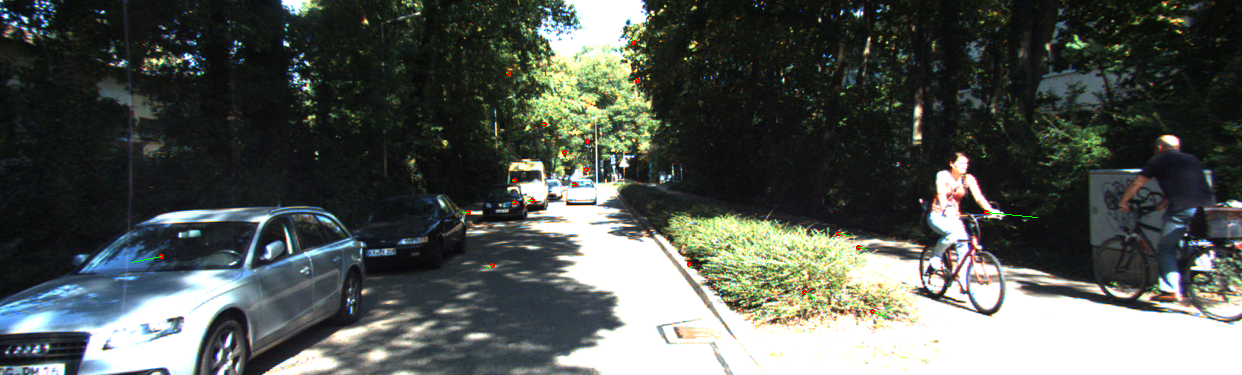

Essential Matrix: [[-1.16677906e-03 -7.06989637e-01 -1.15131318e-02]
 [ 7.06983658e-01 -1.19730880e-03  6.57522594e-03]
 [ 1.10256968e-02 -4.92257570e-03  2.27600923e-05]]
Residuals for corresponding points:
[6.08286241e-04 4.10227795e-04 2.54947663e-04 1.23577091e-03
 1.05331209e-03 5.72109592e-04 6.89399302e-04 3.24315670e-04
 1.40733197e-03 4.23498572e-04 5.48365008e-04 5.90944826e-04
 3.27941494e-04 3.28790791e-04 1.55210475e-04 6.15356348e-04
 7.55256901e-04 1.56387068e-04 1.93945006e-06 6.75265655e-04]
Residuals for random points:
[0.04917058 0.10092086 0.00561968 0.12052348 0.0131651  0.07498217
 0.13918649 0.14415212 0.05298354 0.07584578 0.17698967 0.08965208
 0.09317079 0.14925636 0.04290998 0.05524905 0.00720585 0.03111521
 0.03036987 0.02094513]


In [58]:
img_tn1 = kitti_imgs[0]
img_t = kitti_imgs[1]

# Ground truth corresponding Keypoints in img_tn1 and img_t
kps_tn1 = np.array([[838,233],[508,73],[514,180],[468,212],[587,141],[492,265],[986,212],[633, 42],[872,311],[544,124],
                    [804,292],[858,247],[689,264],[161,256],[574,184],[637,80],[532,200],[514,202],[564,152],[586,169]])

kps_t = np.array([[ 848,235],[506,72],[512,180],[462,212],[587,141],[486,268],[1037,217],[632,39],[886,317],[542,124],
                  [814,298],[867,249],[690,267],[131,262],[572,184],[636,79],[528,200],[512,202],[564,152],[585,169]])
kps_tn1_ = np.column_stack((kps_tn1, np.ones(len(kps_tn1)))) @ np.linalg.inv(kitti_cam_calib).T
kps_t_ = np.column_stack((kps_t, np.ones(len(kps_t)))) @ np.linalg.inv(kitti_cam_calib).T

disp(img_tn1, kps_tn1, kps_t)

E = EssentialMatrixTransform()
E.estimate(kps_tn1_, kps_t_)

print(f"Essential Matrix: {E.params}")

print("Residuals for corresponding points:")
print(E.residuals(kps_tn1_, kps_t_))

print("Residuals for random points:")
permutation = np.random.choice(range(20), replace=False, size=20)
print(E.residuals(kps_tn1_, kps_t_[permutation]))

# Features utils

In [59]:
def extract_features(img):
  """
  Args
    img: numpy array of shape (H,W,C) representing image
  Returns
    kps: numpy array of shape (N, 2) representing coordinates of N
      keypoints detected
    des: numpy array of shape (N, 32) representing 32 dim descriptor
      of N keypoints
  """
  img = np.expand_dims(np.mean(img, axis=2).astype(np.uint8), -1)
  orb = cv2.ORB_create(nfeatures=5000)
  kps, des = orb.detectAndCompute(img, None)
  kps = np.array([[kp.pt[0], kp.pt[1]] for kp in kps]).astype(np.int32)
  return kps, des


def match_features(des_tn1, des_t):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING, crossCheck=True)
  matches = bf_matcher.match(des_tn1, des_t)
  return np.array([[match.queryIdx, match.trainIdx] for match in matches])

def match_features2(des_tn1, des_t, params):
  bf_matcher = cv2.BFMatcher(cv2.NORM_HAMMING)
  matches = bf_matcher.knnMatch(des_tn1, des_t, k=2)

  idx_tn1, idx_t = [], []
  for m1, m2 in matches:
    # Lowe's ratio test
    if m1.distance <= params["lowe_ratio"] * m2.distance:
      if m1.distance < params["max_hamming_distance"]:
        if m1.trainIdx not in idx_t:
          idx_tn1.append(m1.queryIdx)
          idx_t.append(m1.trainIdx)

  assert len(idx_tn1) >= 8, f"#matches: {len(idx_tn1)}" 
  return np.array([idx_tn1, idx_t]).T

# Frame

In [62]:
class Frame:
  def __init__(self, img, K):
    self._img = img
    self._K = K
    self._kps, self._des = extract_features(img)
    self._kps_ = self.normalize(self._kps)

    self.frame2 = None
    self.matches2 = None
    self.E = None
    self.R = None
    self.t = None

    self.matches3 = None
    self.relative_scale = None

  def triangulate(self, kps_idx):
    assert self.frame2 is not None
    matches2_idx, = np.where(self.matches2[:,0] == np.array(kps_idx))
    assert len(matches2_idx) == 1
    matches2_idx = matches2_idx[0]

    return triangulate(
      self.kps_[kps_idx],
      self.frame2.kps_[self.matches2[matches2_idx,1]],
      self.R,
      self.t
    )

  def match2(self, frame2, params):
    self.frame2 = frame2
    self.matches2 = match_features2(
      self.des, self.frame2.des,
      {"lowe_ratio":params["lowe_ratio"],
       "max_hamming_distance":params["max_hamming_distance"]}
    )

    self.E, inliers = ransac(
      (self.kps_[self.matches2[:,0]], self.frame2.kps_[self.matches2[:,1]]),
      EssentialMatrixTransform,
      min_samples=8,
      residual_threshold=params["residual_threshold"],
      max_trials=params["max_trials"]
    )
    self.matches2 = self.matches2[inliers]

    self.R, self.t = essential_to_Rt(
      self.E.params,
      self.kps_[self.matches2[:8,0]],
      self.frame2.kps_[self.matches2[:8,1]]
    )
  
  def match3(self):
    assert self.frame2 is not None
    assert self.frame2.frame2 is not None
    
    self.matches3 = []
    for i, kp in enumerate(self.matches2[:,1]):
      j, = np.where(self.frame2.matches2[:,0] == np.array(kp))
      assert len(j) in [0,1]
      if len(j) == 1:
        j = j[0]
        assert self.matches2[i,1] == self.frame2.matches2[j,0]
        self.matches3.append([self.matches2[i,0], self.matches2[i,1], self.frame2.matches2[j,1]])
    self.matches3 = np.array(self.matches3)
    self.update_relative_scale()

  def update_relative_scale(self):
    ss = 2 * (min(10, len(self.matches3))//2)
    indices = np.random.choice(np.arange(len(self.matches3)), ss, replace=False).reshape(ss//2,2)

    relative_scale = []
    for i, j in indices:
      try:
        x_i_12 =self.triangulate(self.matches3[i,0])
        x_j_12 =self.triangulate(self.matches3[j,0])
        x_i_23 =self.frame2.triangulate(self.matches3[i,1])
        x_j_23 =self.frame2.triangulate(self.matches3[j,1])
      except:
        continue

      relative_scale.append(
        np.linalg.norm(x_i_12 - x_j_12)/
        np.linalg.norm(x_i_23 - x_j_23)
      )
    self.relative_scale = np.median(relative_scale)

  def normalize(self, kps):
    return np.column_stack((
      kps,
      np.ones(len(kps))
    )) @ np.linalg.inv(self._K).T

  @property
  def img(self):
    return self._img

  @property
  def kps(self):
    return self._kps

  @property
  def kps_(self):
    return self._kps_

  @property
  def des(self):
    return self._des

# Main

In [126]:
dataset_id = 1
imgs = [kitti_imgs, freiburgxyz525_imgs][dataset_id]
cam_calib = [kitti_cam_calib, freiburgxyz525_K][dataset_id]

idxs = np.arange(len(imgs))
# idxs = np.arange(len(imgs)).reshape(len(imgs)//2, 2)[:,0]

frames = []
for idx in tqdm(idxs):
  frames.append(Frame(imgs[idx], cam_calib))
  if len(frames) >= 2:
    frames[-2].match2(
      frames[-1],
      {"residual_threshold":0.001,
       "max_trials":100,
       "lowe_ratio":0.9,
       "max_hamming_distance":32
       }
    )
    if len(frames) >= 3:
      frames[-3].match3()

100%|██████████| 798/798 [07:24<00:00,  1.80it/s]


In [137]:
# Obtain trajector
np.eye
trajectory = [np.eye(4, dtype=np.float)]
relative_scale = 1
for i in range(len(frames) - 1):
  T = np.eye(4) # Relative Transformation
  T[:3,:3] = frames[i].R
  T[:3,3] = frames[i].t #* relative_scale
  trajectory.append(
    trajectory[-1] @ T
  )
  if frames[i].relative_scale is not None:
    relative_scale *= frames[i].relative_scale
trajectory = np.array(trajectory)

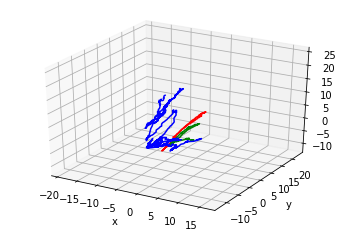

In [138]:
# Plot trajector
ax = plt.axes(projection ='3d')
ax.plot3D(trajectory[:100,0,3], trajectory[:100,2,3], -trajectory[:100,1,3], color='red')
ax.plot3D(trajectory[100:200,0,3], trajectory[100:200,2,3], -trajectory[100:200,1,3], color='green')
ax.plot3D(trajectory[200:,0,3], trajectory[200:,2,3], -trajectory[200:,1,3], color='blue')
plt.xlabel('x')
plt.ylabel('y')
axisEqual3D(ax)
plt.show()

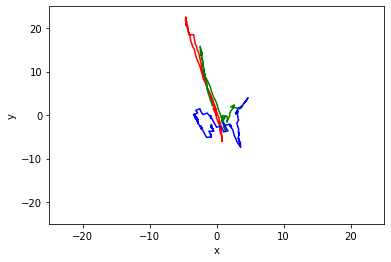

In [143]:
plt.plot(trajectory[:100,0,3], trajectory[:100,2,3], color='red')
plt.plot(trajectory[100:200,0,3], trajectory[100:200,2,3], color='green')
plt.plot(trajectory[200:300,0,3], trajectory[200:300,2,3], color='blue')
plt.xlabel('x')
plt.ylabel('y')
plt.xlim((-25,25))
plt.ylim((-25,25))
# plt.axis('equal')
plt.show()

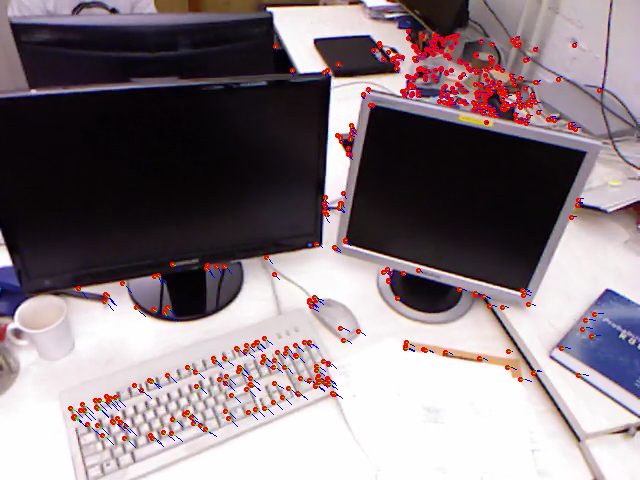

In [140]:
i = 200
disp2(
  frames[i].img,
  frames[i].kps[frames[i].matches3[:,0]],
  frames[i + 1].kps[frames[i].matches3[:,1]],
  frames[i + 2].kps[frames[i].matches3[:,2]]
)